# V-sKNN with CuPy
This notebook was tested on the `rapidsai/rapidsai:cuda11.2-runtime-ubuntu18.04-py3.7` image, with a `Tesla V100` GPU.  
You need to clone https://github.com/jcrousse/VS_KNN_Nvidia_rapids to be able to import all the functions

In [1]:
!pip install wget  # wget missing from the docker image

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=0b245316edb1720ef837c704bc08a31318ab0c19ae3a466d934d4948ca1c9eb2
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [2]:
import argparse
import json
import numpy as np
import cupy as cp
import cudf
import pandas as pd
from cupyx.time import repeat
from vs_knn import CupyVsKnnModel
from vs_knn.train_test_split import train_test_split
from vs_knn.preprocessing import preprocess_data
from vs_knn.index_builder import IndexBuilder
from vs_knn.data_read_write import read_dataset
from vs_knn.col_names import SESSION_ID, TIMESTAMP, ITEM_ID
from tqdm import tqdm

In [3]:
# version > 18 required
cudf.__version__

'21.12.01'

In [4]:
MAX_SESSIONS = None  # use fixed value (such as 10 ** 6) to save memory and time for development

## Create indices
V-sKNN requires two indices:
* `session_to_items`: For N >= 1 `session_id`, returns a CuPy array where the element in position *(i, j)* column contains the j-th item in the i-th input session 
* `item_to_sessions`: For one or more `item_id`, returns a CuPy array where the element in position *(i, j)* column contains the j-th session in the i-th input item 
Any python object that satisfies this property can be used.  
By default the indices are large CuPy matrices, but those can take a lot of the GPU's available memory.  
Alternatively, the option to use host memory pandas arrays is also offered. This is a bit slower, but limited by host memory instead of device memory.  
Finally, the user can also create an object as a wrapper around any key-value store (Redis, RocksDB, ....)

In [5]:
def setup_vsknn_indices(project_config, train_df, max_sessions=None):
    """ returns two key-value stores for session index and item index.
    At the moment it is a simple pandas dataframe behind the scenes, but any object that returns
    CuPy arrays should do"""
    items_per_sessions, sessions_per_item = \
        project_config['items_per_session'], project_config['sessions_per_item']
    train_dataset_path = project_config['data_sources']['train_data']

    index_builder = IndexBuilder(items_per_sessions, sessions_per_item)
    index_builder.create_indices(train_df, max_sessions=max_sessions)


    session_index = index_builder.get_df_index('session', 'pandas')
    item_index = index_builder.get_df_index('item', 'pandas')
    
    return session_index, item_index

## Load project parameters
See/edit `config.json`

In [6]:
with open('config.json', 'r') as f:
    project_config = json.load(f)

# Download pre-processed dataset
From personal google cloud bucket.  
This is the youchoose dataset, where the first 180 days are taken as training set, and the remaining 3 days as test set.  


In [7]:
train_set = read_dataset('train_data', project_config, 'cudf')
test_set = read_dataset('test_data', project_config, 'cudf')

# Utility functions:
Function: 
* `get_test_examples` to get an array of test examples (session_ids from test set)
* `session_to_xy` takes the last item of the session as target value y, and the other items as input session
* `test_a_model` run a model predict function on each element of the test set session by session. Monitors time taken and HR@20

In [8]:
def get_test_examples(test_set):
    test_array = test_set \
        .drop(TIMESTAMP, axis=1) \
        .groupby(SESSION_ID) \
        .agg({ITEM_ID: 'collect'})[ITEM_ID]\
        .to_pandas()\
        .values
    return test_array

In [9]:
test_sessions_array = get_test_examples(test_set)

In [10]:
def session_to_xy(items_in_session):
    return (items_in_session[0:-1], items_in_session[-1]) if len(items_in_session) > 1 else (None, None)

In [11]:
def test_a_model(model, test_data):
    total_hits = 0
    
    pbar = tqdm(test_data)
    hr20 = 0
    for n_treated, test_session in enumerate(pbar):
            x, y = session_to_xy(test_session)
            if x is not None:

                items_pred, item_scores = model.predict(x)
                selection = cp.flip(cp.argsort(item_scores)[-20:])
                items_rec = items_pred[selection]
                
                if y in items_rec:
                    total_hits += 1
                    hr20 = total_hits / n_treated
                    pbar.set_postfix({'HR@20': hr20})

    time_per_iter = pbar.format_dict['elapsed'] / pbar.format_dict['n']

    return time_per_iter, hr20


# Baseline: Identity model
This already gives us an idea of the theoritical max speed of the test function, plus also a performance baseline for predictions.  
With this 'model', the input session is returned as output predicted items, with linearly increasing scores.  
Performances are already better than random, as there are good chances that a user interracts with an item that is already in the current session.  

In [12]:
class IdentityModel:
    def predict(self, x):
        return cp.array(x), cp.arange(len(x))

In [13]:
indentity_model = IdentityModel()

In [14]:
itertime_id, hr_id = test_a_model(indentity_model, test_sessions_array)

100%|██████████| 53321/53321 [00:48<00:00, 1106.16it/s, HR@20=0.236]


In [15]:
print(f"{itertime_id * 1000} miliseconds per request")

0.9040357435154934 miliseconds per request


# V-sKNN with a Pandas DataFrame as item and session indices
In this experiment, we use pandas dataframes as session and item indices

In [49]:
session_to_items_pd, item_to_sessions_pd = setup_vsknn_indices(project_config, train_set, MAX_SESSIONS)

In [50]:
model_pd = CupyVsKnnModel(item_to_sessions_pd, session_to_items_pd, top_k=project_config['top_k'])

In [51]:
itertime_pd, hr_pd = test_a_model(model_pd, test_sessions_array)

100%|██████████| 53321/53321 [05:31<00:00, 160.88it/s, HR@20=0.327]


In [52]:
print(f"{itertime_pd * 1000} miliseconds per request")

6.215756238306126 miliseconds per request


# How fast would it be if we generated random CuPy arrays instead of reading from an index?
Goal is to see how fast the algorithm goes and compare different approaches

In [53]:
class RandomIndex:
    def __init__(self, width):
        self.width = width
    def __getitem__(self, item):
        return cp.random.randint(0, 1000, (len(item), self.width))

In [54]:
session_to_items_rd = RandomIndex(project_config['items_per_session'])
item_to_sessions_rd = RandomIndex(project_config['sessions_per_item'])

In [55]:
model_rd = CupyVsKnnModel(item_to_sessions_rd, session_to_items_rd, top_k=project_config['top_k'])

In [58]:
itertime_rd, hr_rd = test_a_model(model_rd, test_sessions_array)

100%|██████████| 53321/53321 [04:26<00:00, 199.71it/s, HR@20=0.0014]  


In [59]:
print(f"{itertime_rd * 1000} miliseconds per request")

5.007278038134075 miliseconds per request


# How fast would it be if the values were already on the device?
This time the index selects slices of randomly generated static CuPy arrays that are already on the device.  
Contrary to the "random index" above, they are generated only once.

In [16]:
session_to_items_sample, item_to_sessions_sample = setup_vsknn_indices(project_config, train_set, 10000)

In [22]:
zero_pct_session = (session_to_items_sample.index_df == 0).sum().sum() / (session_to_items_sample.index_df.shape[0] * session_to_items_sample.index_df.shape[1])
zero_pct_items = (item_to_sessions_sample.index_df == 0).sum().sum() / (item_to_sessions_sample.index_df.shape[0] * item_to_sessions_sample.index_df.shape[1])

print(f"Percentage of zero values in session index: {zero_pct_session}")
print(f"Percentage of zero values in item index: {zero_pct_items}")

Percentage of zero values in session index: 0.7210821082108211
Percentage of zero values in item index: 0.9809150117953761


In [29]:
class StaticDeviceIndex:
    def __init__(self, width, zero_pct=0.5):
        self.width = width
        zero_mask = (cp.random.random((10000, self.width)) < zero_pct)
        self.return_value = cp.random.randint(0, 1000, (10000, self.width)) * zero_mask
    def __getitem__(self, item):
        return self.return_value[0:len(item), :]

In [30]:
session_to_items_st = StaticDeviceIndex(project_config['items_per_session'], zero_pct_session)
item_to_sessions_st = StaticDeviceIndex(project_config['sessions_per_item'], zero_pct_items)

In [31]:
model_st = CupyVsKnnModel(item_to_sessions_st, session_to_items_st, top_k=project_config['top_k'])

In [32]:
itertime_st, hr_st = test_a_model(model_st, test_sessions_array)

100%|██████████| 53321/53321 [03:39<00:00, 242.62it/s, HR@20=0.000549]


In [33]:
print(f"{itertime_st * 1000} miliseconds per request")

4.12166948286824 miliseconds per request


In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

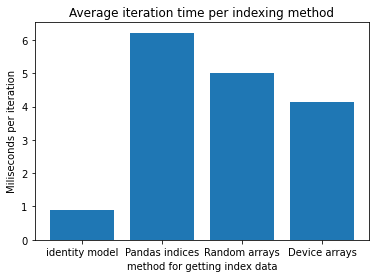

In [63]:
time_values = [itertime_id, itertime_pd, itertime_rd,  itertime_st]
label_values = ["identity model", "Pandas indices", "Random arrays", "Device arrays"]

time_miliseconds = [e * 1000 for e in time_values]

plt.bar(label_values, time_miliseconds)
plt.xlabel("method for getting index data")
plt.ylabel("Miliseconds per iteration")
plt.title("Average iteration time per indexing method")
plt.show()

# Conclusions & Next steps

While the method chosen for indices does impact the model response time, it seem that there is little gain to obta